# Kaggle

В этом домашнем задании вам нужно будет построить модель для данных соревнования [Titanic на Kaggle](https://www.kaggle.com/c/titanic/overview), сформировать файл с предсказаниями для тестовых данных и отправить его на проверку.

В практике из урока вашим заданием было разобрать одно из самых популярных ядер для соревнования Titanic и преобразовать его таким образом, чтобы остались только преобразование данных и графики.

Соответственно, сейчас ваше ядро должно выглядеть таким образом:

In [1]:
import pandas as pd
import re
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load in the train and test datasets
train = pd.read_csv('data/titanic/train.csv')
test = pd.read_csv('data/titanic/test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
full_data = [train, test]

# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [4]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [5]:
train.head(5)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2
3,1,1,0,2,0,3,0,44,1,2,0,3
4,0,3,1,2,0,1,0,24,0,1,1,1


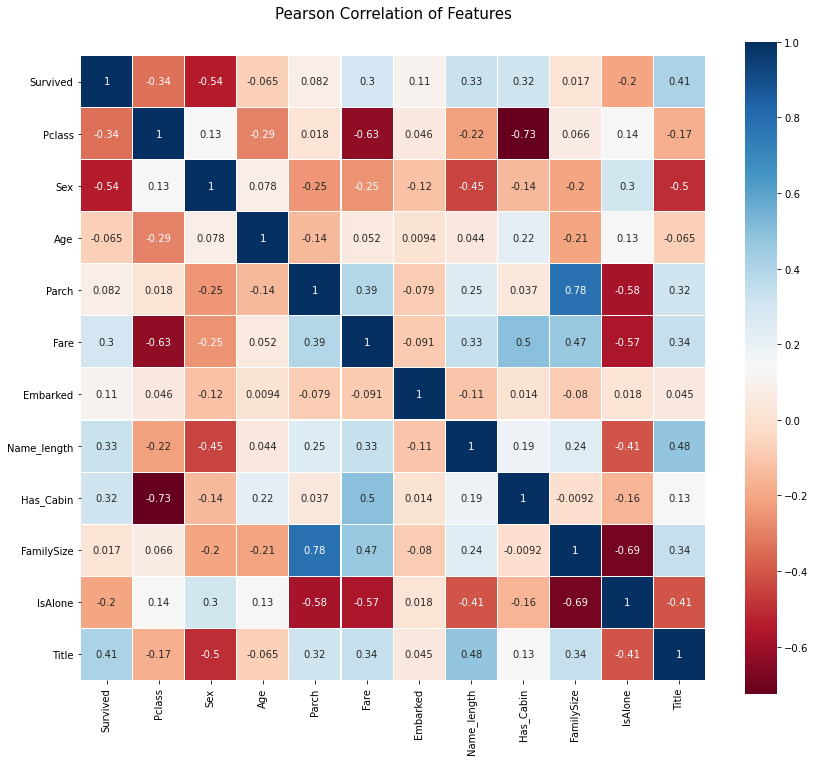

In [6]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

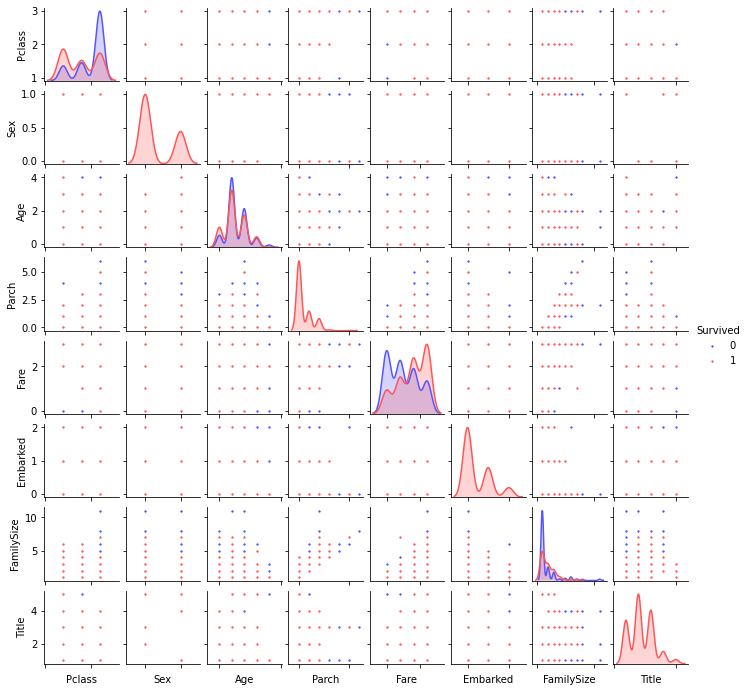

In [7]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', 
                        u'Embarked', u'FamilySize', u'Title']], 
                 hue='Survived', palette = 'seismic', size=1.2, plot_kws=dict(s=10))
g.set(xticklabels=[])

Итак, у нас получились два датасета с новыми признаками. Теперь приступим к построению модели.

## Построение модели

### 1. Свои методы реализации Stacking

Воспользуйтесь вашим алгоритмом стекинга из предыдущего домашнего задания. В качестве базовых алгоритмов используйте RandomForestClassifier, SVC, GradientBoostingClassifier и LogisticRegression; в качестве мета-алгоритма - XGBoost.

Разделите данные train на тренировочную и валидационную выборки с random_state=17 и параметром разбиения test_size=.3 (в качестве целевой переменной возьмите столбец Survived, а в качестве признаков - все остальные столбцы).

Ниже приведены параметры для каждого из базовых алгоритмов, которые необходимо настроить на 5-кратной кросс-валидации с помощью GridSearchCV:

In [8]:
from sklearn.model_selection import (GridSearchCV,
                                     train_test_split,
                                     StratifiedKFold)

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier, Pool
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

# параметры базовых алгоритмов
gbc_params = {'learning_rate': np.arange(0.1, 0.6, 0.1)} # GradientBoostingClassifier

rfc_params = {'n_estimators': range(10, 100, 10), # RandomForestClassifier
              'min_samples_leaf': range(1, 5)}

svc_params = {'kernel': ['linear', 'rbf'], # SVC
              'C': np.arange(0.1, 1, 0.2)}

lr_params = {'C': np.arange(0.5, 1, 0.1)}

skf = StratifiedKFold(n_splits=5, random_state=17)

In [9]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict

def stacking(models, meta_alg, data_train, targets_train, data_test, targets_test=None, random_state=None, test_size=None, cv=5):
    if test_size is None:
        meta_mtrx = np.empty((targets_train.shape[0], len(models)))
        for n, model in enumerate(models):
            meta_mtrx[:, n] = cross_val_predict(model, data_train, targets_train, cv=cv, method='predict')
            model.fit(data_train, targets_train)
        # Обучение мета-алгоритма
        meta_alg.fit(meta_mtrx, targets_train)
        # Формируем матрицу предсказаний базовых алгоримов по тестовым данным
        meta_mtrx_test = np.empty((data_test.shape[0], len(models))) 
        for n, model in enumerate(models):
            meta_mtrx_test[:, n] = model.predict(data_test)
        # Делаем предсказание мета-алгоритма на тестовых данных
        meta_predict = meta_alg.predict(meta_mtrx_test)
        # Вычисление метрик
        if targets_test is not None:
            print(f'Stacking accuracy: {accuracy_score(targets_test, meta_predict)}')
        return meta_predict
    
    elif test_size > 0 and test_size < 1:
        train, valid, train_true, valid_true = train_test_split(data_train, 
                                                    targets_train,
                                                    test_size=test_size,
                                                    random_state=random_state)
        meta_mtrx = np.empty((valid.shape[0], len(models)))
        for n, model in enumerate(models):
            model.fit(train, train_true)
            meta_mtrx[:, n] = model.predict(valid)
        # Обучение мета-алгоритма
        meta_alg.fit(meta_mtrx, valid_true)
        # Формируем матрицу предсказаний базовых алгоримов по тестовым данным
        meta_mtrx_test = np.empty((data_test.shape[0], len(models))) 
        for n, model in enumerate(models):
            meta_mtrx_test[:, n] = model.predict(data_test)
        # Делаем предсказание мета-алгоритма на тестовых данных
        meta_predict = meta_alg.predict(meta_mtrx_test)
        if targets_test is not None:
            print(f'Stacking accuracy: {accuracy_score(targets_test, meta_predict)}')
        return meta_predict
    
    else:
        raise ValueError("test_size must be between 0 and 1")

In [32]:
X = train.iloc[:,1:].copy()
y = train.iloc[:,0].copy()
x_train, x_test, y_train, y_test = train_test_split(X, y,
                    random_state=17, test_size=0.3)

### 2.
1. Определите объект GridSearchCV для всех приведенных параметров каждого алгоритма (в гиперпараметрах алгоритма при его определении, если возможно, укажите random_state=17). Параметр cv устанавливайте равным skf.

2. Обучите каждый из объектов из 1-го пункта на получившейся при разбиении тренировочной выборке. Выведите лучшее сочетание параметров для каждого из алгоритмов.

3. Для каждого обученного алгоритма получите предсказания на валидационных данных и выведите метрику качества, которая соответствует метрике оценки соревнования.

In [33]:
# ваш код 
from sklearn.metrics import accuracy_score

In [34]:
gbg = GridSearchCV(GradientBoostingClassifier(), gbc_params, cv=skf, n_jobs=4)
gbg.fit(x_train, y_train)
print('GradientBoostingClassifier:', gbg.best_params_, gbg.best_score_,
     accuracy_score(y_test, gbg.predict(x_test)))

rfg = GridSearchCV(RandomForestClassifier(), rfc_params, cv=skf, n_jobs=4)
rfg.fit(x_train, y_train)
print('RandomForestClassifier:', rfg.best_params_, rfg.best_score_, 
      accuracy_score(y_test, rfg.predict(x_test)))

svg = GridSearchCV(SVC(), svc_params, cv=skf, n_jobs=4)
svg.fit(x_train, y_train)
print('SVC:', svg.best_params_, svg.best_score_, 
      accuracy_score(y_test, svg.predict(x_test)))

lrg = GridSearchCV(LogisticRegression(), lr_params, cv=skf, n_jobs=4)
lrg.fit(x_train, y_train)
print('LogisticRegression:', lrg.best_params_, lrg.best_score_, 
      accuracy_score(y_test, lrg.predict(x_test)))

GradientBoostingClassifier: {'learning_rate': 0.1} 0.8314709677419355 0.7723880597014925
RandomForestClassifier: {'min_samples_leaf': 4, 'n_estimators': 50} 0.8378451612903227 0.7798507462686567
SVC: {'C': 0.1, 'kernel': 'linear'} 0.804116129032258 0.7873134328358209
LogisticRegression: {'C': 0.5} 0.8185806451612903 0.7985074626865671


In [118]:
cbg = CatBoostClassifier(verbose=False, custom_loss='Accuracy', iterations=1000)
cbg.fit(x_train, y_train)
print('CatBoostClassifier:', cbg.best_iteration_, cbg.best_score_, accuracy_score(y_test, cbg.predict(x_test)))

CatBoostClassifier: None {'learn': {'Accuracy': 0.9165329052969502, 'Logloss': 0.23739826931849353}} 0.7873134328358209


In [36]:
print('Важность признаков для алгоритма:')
print(pd.Series(data=cbg.feature_importances_, index=cbg.feature_names_)
      .sort_values(ascending=False).to_string())

Важность признаков для алгоритма:
Title          20.032757
Sex            16.011075
Pclass         13.656609
Name_length    12.024113
Fare            8.138839
FamilySize      7.968641
Age             7.553255
Embarked        6.025304
Has_Cabin       5.360319
Parch           2.356315
IsAlone         0.872773


In [122]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]
# categorical_features_indices = ['Pclass', 'Sex', 'Age', 'Parch', 'Fare', 
#                         'Embarked', 'Name_length', 'Has_Cabin', 'FamilySize', 
#                                 'IsAlone', 'Title']

validate_pool = Pool(x_test, y_test, cat_features=categorical_features_indices)
train_pool = Pool(x_train, y_train, cat_features=categorical_features_indices)

cbg2 = CatBoostClassifier(verbose=False, use_best_model=True, eval_metric='Accuracy', iterations=1000
                          , early_stopping_rounds=50)

cbg2.fit(train_pool, eval_set=validate_pool, plot=True)
print('CatBoostClassifier:', accuracy_score(y_test, cbg2.predict(x_test)))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CatBoostClassifier: 0.7761194029850746


In [38]:
# Теперь попробуем GridSearch. Будем оптимизировать параметры l2_leaf_reg and learning_rate
# как-то так 
# params_space = {
#     'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1),
#     'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
# }
cbc_params = {'l2_leaf_reg': range(0, 2, 1),
              'learning_rate': np.arange(1e-3, 5e-1)}

cb_model = CatBoostClassifier(iterations=500, eval_metric='Accuracy', random_seed=42, 
                              verbose=False, loss_function='Logloss')
cbg = GridSearchCV(cb_model, cbc_params, cv=skf, n_jobs=4)
cbg.fit(x_train, y_train)
print('CatBoostClassifier:', cbg.best_params_, cbg.best_score_, 
      accuracy_score(y_test, cbg.predict(x_test)))

CatBoostClassifier: {'l2_leaf_reg': 0, 'learning_rate': 0.001} 0.8345935483870968 0.7985074626865671


### 3.
С помощью GridSearchCV и указанных ниже параметров настройте мета-алгоритм на мета-признаках (используйте 5-кратную валидацию и random_state=17 при определении алгоритма). Матрицу метапризнаков получите из предсказаний, полученных в предыдущем пункте на валидационных данных базовыми алгоритмами. Выведите лучшие параметры.

In [39]:
xgb_params = {'n_estimators': range(10, 100, 5),
              'eta': np.arange(0.1, 1., .1),
              'min_child_weight': range(1, 10, 1),
              'subsample': np.arange(0.1, 1., 0.2)}

In [133]:
# ваш код
xgb_model = XGBClassifier(random_state=17)
xbg = GridSearchCV(xgb_model, xgb_params, cv=skf, n_jobs=-1, verbose=1)
xbg.fit(x_train, y_train)
print('XGBClassifier:', xbg.best_params_, xbg.best_score_, 
      accuracy_score(y_test, xbg.predict(x_test)))

Fitting 5 folds for each of 7290 candidates, totalling 36450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-1)]: Done 7056 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 9656 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 12656 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 16056 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 19856 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 24056 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 28656 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 33656 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 36435 out of 36450 | elapsed:  7.1min remaining:    0.1s


XGBClassifier: {'eta': 0.1, 'min_child_weight': 2, 'n_estimators': 20, 'subsample': 0.9000000000000001} 0.8426838709677419 0.8022388059701493


[Parallel(n_jobs=-1)]: Done 36450 out of 36450 | elapsed:  7.1min finished


In [40]:
# Теперь соберем матрицу метапризнаков из предсказаний предыдущих алгоритмов
models = [gbg, rfg, svg, lrg]
meta_mtrx = np.empty((y_train.shape[0], len(models)))
for n, model in enumerate(models):
    meta_mtrx[:, n] = model.predict(x_train)
xbg_meta = GridSearchCV(xgb_model, xgb_params, cv=skf, n_jobs=-1, verbose=1)
xbg_meta.fit(meta_mtrx, y_train)
# print('XGBClassifier:', xbg_meta.best_params_, xbg_meta.best_score_, 
#       accuracy_score(y_test, xbg.predict(x_test)))

Fitting 5 folds for each of 7290 candidates, totalling 36450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 1536 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 2936 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 4736 tasks      | elapsed:   58.2s
[Parallel(n_jobs=-1)]: Done 6936 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 9536 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 12536 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 15936 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 19736 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 23936 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 28536 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 33536 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 36435 out of 36450 | elapsed:  5.1min remaining:    0.0s
[Parallel(n_jobs

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=False),
             estimator=XGBClassifier(random_state=17), n_jobs=-1,
             param_grid={'eta': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'min_child_weight': range(1, 10),
                         'n_estimators': range(10, 100, 5),
                         'subsample': array([0.1, 0.3, 0.5, 0.7, 0.9])},
             verbose=1)

### 4. Построение stacking
На основе алгоритма из предыдущего домашнего задания постройте стекинг (используйте 5-кратную кросс-валидацию) для всех моделей с наилучшими подобранными параметрами. В качестве тренировочных данных используйте весь датасет train.csv, а в качестве тестовых - весь датасет test.csv. Сделайте прогноз мета-алгоритма для test.csv.

In [41]:
# ваш код
models = [gbg, rfg, svg, lrg]
meta_alg = xbg_meta
predictions = stacking(models, meta_alg, X, y, test, test_size=None, random_state=17, cv=5)
predictions

Fitting 5 folds for each of 7290 candidates, totalling 36450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 2960 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 4760 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done 6960 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 9560 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 12560 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 15960 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 19760 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 23960 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 28560 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 33560 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 36435 out of 36450 | elapsed:  6.0min remaining:    0.0s
[Parallel(n_jobs

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [ ]:
# print('meta_alg - XGBClassifier:', meta_alg.best_params_, meta_alg.best_score_, 
#       accuracy_score(y_test, meta_alg.predict(x_test)))

### 5.
С помощью нижеприведенной функции сформируйте файл посылки для соревнования и отправьте на Kaggle.

In [28]:
def write_to_submission_file(predictions, PassengerID, out_file='compute/Submission.csv', columns=['PassengerID', 'Survived']):
    predicted_df = pd.DataFrame(np.array([PassengerId, predictions]).T, columns=columns)
    predicted_df.to_csv(out_file, index=False)

In [42]:
# ваш код
test_out = pd.read_csv('data/titanic/test.csv')
write_to_submission_file(predictions, test_out['PassengerId'],
                        out_file='compute/Submission_stacking.csv')

In [41]:
test_out = pd.read_csv('data/titanic/test.csv')
test_out['PassengerId']

0       892
1       893
2       894
3       895
4       896
       ... 
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64

### 6. Публикация результатов и выводы
Каков результат score, полученного на соревновании?

Ваш ответ:
После стэкинга предложенных алгоритмов получен скор: 0.76794, или попадание в 66% лучших результатов

Продолжил эксперименты с моделями. Лучшего скора удалось добиться от бэггинга CatBoost'a - скор 0.78708, 3943 место или попадание в 17% лучших результатов.

Чуть хуже - просто CatBoost на GPU с рекомендованными параметрами, и передачей внутрь валидационного датасета
```train_pool = Pool(x_train, y_train, cat_features=categorical_features_indices)
test_pool = Pool(x_test, y_test, cat_features=categorical_features_indices) 
cb_gpu = CatBoostClassifier(verbose=False, task_type='GPU', eval_metric='Accuracy')
cb_gpu.fit(train_pool, eval_set=test_pool, use_best_model=True)```


Остальные методы, включая стэкинг с совсем разными параметрами, не смогли приблизиться к данному результату.

Удивило, что обучение на полном датасете давало практически всегда итоговый скор от Kaggle хуже, чем запуск этого же кода, но на train части этого же датасета.

Ниже приведены мои эксперименты с алгоритмами. Включая Stacking по GradientBoosting, RandomForest, SVC,  LinearRegression, XGBClassifier, CatBoostClassifier на нижнем уровне, с подобранными GridSearchCV гиперпараметрами. Алгоритм второго уровня я взял CatBoost.

### Тестирую CatBoost с перебором гиперпараметров hyperopt

In [20]:
# Теперь поиграемся с hyperopt как в мануале к CatBoost
# !pip install hyperopt

In [20]:
import hyperopt
from catboost import cv

def hyperopt_objective(params):
    model = CatBoostClassifier(
        l2_leaf_reg=int(params['l2_leaf_reg']),
        learning_rate=params['learning_rate'],
        iterations=500,
        eval_metric='Accuracy',
        random_seed=42,
        verbose=False,
        loss_function='Logloss',
    )
    
    cv_data = cv(
        Pool(X, y, cat_features=categorical_features_indices),
        model.get_params()
    )
    best_accuracy = np.max(cv_data['test-Accuracy-mean'])
    
    return 1 - best_accuracy # as hyperopt minimises

In [21]:
from numpy.random import RandomState

params_space = {
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=RandomState(123)
)

print(best)

100%|██████████████████████████████████████████████| 50/50 [1:04:15<00:00, 77.10s/trial, best loss: 0.1661054994388328]
{'l2_leaf_reg': 2.0, 'learning_rate': 0.45196799057686576}


In [22]:
# Now let's get all cv data with best parameters
model = CatBoostClassifier(
    l2_leaf_reg=int(best['l2_leaf_reg']),
    learning_rate=best['learning_rate'],
    iterations=500,
    eval_metric='Accuracy',
    random_seed=42,
    verbose=False,
    loss_function='Logloss',
)
cv_data = cv(Pool(X, y, cat_features=categorical_features_indices), model.get_params())

In [23]:
print('Precise validation accuracy score: {}'.format(np.max(cv_data['test-Accuracy-mean'])))

Precise validation accuracy score: 0.8338945005611672


In [30]:
cb_h = model.fit(X, y, cat_features=categorical_features_indices)
cb_hyper_predicts = model.predict(test)
test_out = pd.read_csv('data/titanic/test.csv')
write_to_submission_file(cb_hyper_predicts, test_out['PassengerId'],
                        out_file='compute/Submission_cb_h.csv')

In [31]:
print(cb_hyper_predicts)

[0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 1 0 0
 0 0 0 0 1 0 1 1 0 1 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0
 1 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 0
 0 1 1 1 1 0 0 1 0 0 1]


Kaggle Score: 0.76794

Еще один вариант модели

In [141]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from catboost import Pool, CatBoostClassifier

model2 = CatBoostClassifier(loss_function="Logloss",
                           eval_metric="Accuracy",
                           task_type="GPU",
                           learning_rate=0.01,
                           iterations=70000,
                           l2_leaf_reg=50,
                           random_seed=432013,
                           od_type="Iter",
                           depth=5,
                           early_stopping_rounds=15000,
                           border_count=64
                           #has_time= True 
                          )

n_split = 15
kf = KFold(n_splits=n_split, random_state=17, shuffle=True)



### Тестирую Bagging

In [49]:
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification

In [76]:
%%time
# X_bg, y_bg = make_classification(n_samples=100, n_features=4,
#                                  n_informative=2, n_redundant=0, 
#                                  random_state=0, shuffle=False)

cbc_b = CatBoostClassifier(verbose=False, cat_features=categorical_features_indices, task_type='CPU' )
bc_cb = BaggingClassifier(base_estimator= cbc_b, n_estimators=10, random_state=17, verbose=1,
                       n_jobs=4)
bc_cb.fit(x_train, y_train)
print('Accuracy score:', accuracy_score(y_test, bc_cb.predict(x_test)))
bc_cb_predicts = bc_cb.predict(test)
write_to_submission_file(bc_cb_predicts, test_out['PassengerId'],
                        out_file='compute/Submission_bc_cb.csv')

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.5min remaining:  1.5min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.0min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Accuracy score: 0.7723880597014925
Wall time: 2min 1s


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


Score in Kaggle: 0.78708, 3943 place in Kaggle

In [77]:
%%time
train_pool = Pool(x_train, y_train, cat_features=categorical_features_indices)
test_pool = Pool(x_test, y_test, cat_features=categorical_features_indices) 
bc_cb2 = BaggingClassifier(
    base_estimator = CatBoostClassifier(verbose=False, task_type='CPU', 
                                        cat_features=categorical_features_indices ),
    n_estimators = 15, random_state = 17, verbose = 1,  n_jobs = 4)
bc_cb2.fit(x_train, y_train)
bc_cb2_predicts = bc_cb2.predict(test)
print('Accuracy score:', accuracy_score(y_test, bc_cb2.predict(x_test)))

write_to_submission_file(bc_cb2_predicts, test_out['PassengerId'],
                        out_file='compute/Submission_bc_cb2.csv')

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  2.9min remaining:  2.9min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.9min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished


Accuracy score: 0.7723880597014925
Wall time: 2min 54s


Беру последную модель на полном датасете

In [78]:
%%time
bc_cb_notest = BaggingClassifier(
    base_estimator = CatBoostClassifier(verbose=False, task_type='CPU', 
                                        cat_features=categorical_features_indices ),
    n_estimators = 15, random_state = 17, verbose = 1,  n_jobs = 4
                                ).fit(X, y)
bc_cb_notest_predicts = bc_cb_notest.predict(test)
print('Accuracy score (means not to be correct):', accuracy_score(y_test, bc_cb_notest.predict(x_test)))

write_to_submission_file(bc_cb_notest_predicts, test_out['PassengerId'],
                        out_file='compute/Submission_bc_cb_notest.csv')

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  3.1min remaining:  3.1min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  3.1min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished


Accuracy score (means not to be correct): 0.8432835820895522
Wall time: 3min 8s


Kaggle Score: 0.77272. Получилось хуже

In [79]:
%%time
bc_cb_notest2 = BaggingClassifier(
    base_estimator = CatBoostClassifier(verbose=False, task_type='CPU', 
                                        cat_features=categorical_features_indices ),
    n_estimators = 10, random_state = 17, verbose = 1,  n_jobs = 4
                                ).fit(X, y)
bc_cb_notest2_predicts = bc_cb_notest2.predict(test)
print('Accuracy score (means not be correct):', accuracy_score(y_test, bc_cb_notest2.predict(x_test)))

write_to_submission_file(bc_cb_notest2_predicts, test_out['PassengerId'],
                        out_file='compute/Submission_bc_cb_notest2.csv')

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.8min remaining:  1.8min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.3min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Accuracy score (means not be correct): 0.8432835820895522
Wall time: 2min 16s


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


Kaggle Score: 0.77033. Еще хуже

Теперь попробуем на GPU

In [93]:
%%time
bc_cb_gpu = BaggingClassifier(
    base_estimator = CatBoostClassifier(verbose=False, task_type='GPU', 
                                        cat_features=categorical_features_indices, eval_metric='Accuracy' ),
    n_estimators = 10, random_state = 17, verbose = 1,  n_jobs = 1
                                ).fit(X, y)
print('Accuracy score (on GPU):', accuracy_score(y_test, bc_cb_gpu.predict(x_test)))
write_to_submission_file(bc_cb_gpu.predict(test), test_out['PassengerId'],
                        out_file='compute/Submission_bc_cb_gpu.csv')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy score (on GPU): 0.8432835820895522
Wall time: 24min 12s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 24.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Kaggle Score: 0.75598

Accuracy score (on GPU): 0.8432835820895522

### Другие эксперименты с CatBoost

In [84]:
%%time
train_pool = Pool(x_train, y_train, cat_features=categorical_features_indices)
test_pool = Pool(x_test, y_test, cat_features=categorical_features_indices) 

cb_gpu = CatBoostClassifier(verbose=False, task_type='GPU')
cb_gpu.fit(train_pool, eval_set=test_pool, use_best_model=True)
print('Accuracy score:', accuracy_score(y_test, cb_gpu.predict(x_test)))

Accuracy score: 0.7761194029850746
Wall time: 2min 7s


In [86]:
write_to_submission_file(cb_gpu.predict(test), test_out['PassengerId'],
                        out_file='compute/Submission_cb_gpu.csv')

Kaggle Score: 0.76794

In [89]:
%%time
cb_gpu = CatBoostClassifier(verbose=False, task_type='GPU', eval_metric='Accuracy')
cb_gpu.fit(train_pool, eval_set=test_pool, use_best_model=True)
print('Accuracy score:', accuracy_score(y_test, cb_gpu.predict(x_test)))

Accuracy score: 0.8022388059701493
Wall time: 2min 17s


In [90]:
write_to_submission_file(cb_gpu.predict(test), test_out['PassengerId'],
                        out_file='compute/Submission_cb_gpu_accuracy.csv')

Kaggle Score: 0.78229

In [92]:
%%time
cb_cpu = CatBoostClassifier(verbose=False, task_type='CPU', eval_metric='Accuracy', iterations=5000)
cb_cpu.fit(train_pool, eval_set=test_pool, use_best_model=True)
print('Accuracy score:', accuracy_score(y_test, cb_cpu.predict(x_test)))
write_to_submission_file(cb_gpu.predict(test), test_out['PassengerId'],
                        out_file='compute/Submission_cb_cpu_accuracy.csv')

In [108]:
cb_cpu.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Accuracy',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 5000,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBord

Kaggle Score: 0.78229

Теперь пробуем GridSearch

In [115]:
cb_classifier = CatBoostClassifier(verbose=False, task_type='CPU', eval_metric='Accuracy', 
                                   iterations=5000, early_stopping_rounds=50, cat_features=categorical_features_indices )
grid = {'learning_rate': [0.01, 0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}
cb_grid = cb_classifier.grid_search(grid, X=X, y=y, cv=5, stratified=True, partition_random_seed=17, verbose=False)
print('The best params:', cb_grid['params'])

Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8156424581
bestIteration = 23

Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8100558659
bestIteration = 6

Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8212290503
bestIteration = 43

Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8156424581
bestIteration = 10

Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8100558659
bestIteration = 6

Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8156424581
bestIteration = 62

Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8100558659
bestIteration = 5

Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8100558659
bestIteration = 6

Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8212290503
bestIteration = 15

Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8100558659
bestIteration = 7

Stopped by over

In [116]:
print('Accuracy score:', accuracy_score(y, cb_classifier.predict(X)))
write_to_submission_file(cb_classifier.predict(test), test_out['PassengerId'],
                        out_file='compute/Submission_cb_classifier.csv')

Accuracy score: 0.8956228956228957


Kaggle Score: 0.76076

## Теперь изучаю работу StackingClassifier из sklearn

In [123]:
from sklearn.ensemble import StackingClassifier

In [131]:
stack_models = [('GradientBoosting',gbg),
                ('RandomForest', rfg),
                ('SVC', svg),
                ('LinearRegression', lrg)]

stack_final_estimator = xbg_meta
stack_cl = StackingClassifier(estimators=stack_models, final_estimator=stack_final_estimator )
stack_cl.fit(x_train, y_train)
print('StackingClassifier:', accuracy_score(y_test, stack_cl.predict(x_test)))
write_to_submission_file(stack_cl.predict(test), test_out['PassengerId'],
                        out_file='compute/Submission_stack_cl.csv')

Fitting 5 folds for each of 7290 candidates, totalling 36450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 1536 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 2936 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 4736 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 6936 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 9536 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 12536 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 15936 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 19736 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 23936 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 28536 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 33536 tasks      | elapsed:  5.6min


StackingClassifier: 0.7910447761194029


[Parallel(n_jobs=-1)]: Done 36450 out of 36450 | elapsed:  6.0min finished


Kaggle Score: 0.77511

In [132]:
stack_cl.fit(X, y)
print('StackingClassifier:', accuracy_score(y_test, stack_cl.predict(x_test)))
write_to_submission_file(stack_cl.predict(test), test_out['PassengerId'],
                        out_file='compute/Submission_stack_cl_whole.csv')

Fitting 5 folds for each of 7290 candidates, totalling 36450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 2960 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 4760 tasks      | elapsed:   51.0s
[Parallel(n_jobs=-1)]: Done 6960 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 9560 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 12560 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 15960 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 19760 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 23960 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 28448 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 33448 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 36450 out of 36450 | elapsed:  6.4min finished


StackingClassifier: 0.8619402985074627


Kaggle Score: 0.76315

### Stacking над лучшими предыдущими моделями

In [135]:
stack_models_best = [('GradientBoosting',gbg),
                ('RandomForest', rfg),
                ('SVC', svg),
                ('LinearRegression', lrg),
                ('XGBClassifier', xbg),
                ('CatBoostClassifier', bc_cb)]
stack_final_estimator_best = CatBoostClassifier(verbose=False, task_type='CPU', 
                                                eval_metric='Accuracy', iterations=5000)
stack_cl_best = StackingClassifier(estimators=stack_models_best, 
                                   final_estimator=stack_final_estimator_best )
stack_cl_best.fit(x_train, y_train)
print('StackingClassifier:', accuracy_score(y_test, stack_cl_best.predict(x_test)))
write_to_submission_file(stack_cl_best.predict(test), test_out['PassengerId'],
                        out_file='compute/Submission_stack_cl_best.csv')

Fitting 5 folds for each of 7290 candidates, totalling 36450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 2960 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 4760 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done 6960 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 9560 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 12560 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 15960 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 19760 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 23960 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 28456 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 33456 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 36435 out of 36450 | elapsed:  6.7min remaining:    0.1s
[Parallel(n_jobs

Fitting 5 folds for each of 7290 candidates, totalling 36450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 2960 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 4760 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done 6960 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 9560 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 12560 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 15960 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 19760 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 23960 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 28560 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 33560 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 36450 out of 36450 | elapsed:  6.8min finished
[Parallel(n_jobs=-1)]: Usi

Fitting 5 folds for each of 7290 candidates, totalling 36450 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-1)]: Done 7056 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 9656 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 12656 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 16056 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 19856 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 24056 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 28656 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 33656 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 36450 out of 36450 | elapsed:  6.3min finished


Fitting 5 folds for each of 7290 candidates, totalling 36450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 6000 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done 8960 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 11160 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 13760 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 16760 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 20160 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 23960 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 28160 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 32760 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 36435 out of 36450 | elapsed:  5.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 36450 out of 36450 | elapsed:  5.7min finished


Fitting 5 folds for each of 7290 candidates, totalling 36450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 6000 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done 9600 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 14000 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 19200 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 25200 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 32000 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 36450 out of 36450 | elapsed:  5.6min finished


Fitting 5 folds for each of 7290 candidates, totalling 36450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 3128 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 4928 tasks      | elapsed:   47.4s
[Parallel(n_jobs=-1)]: Done 7128 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 9728 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 12728 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 16128 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 19928 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 24128 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 28728 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 33728 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 36450 out of 36450 | elapsed:  5.6min finished
[Parallel(n_jobs=4)]: Usin

StackingClassifier: 0.7686567164179104


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


Kaggle Score: 0.77751

In [136]:
stack_models_best = [('GradientBoosting',gbg),
                ('RandomForest', rfg),
                ('SVC', svg),
                ('LinearRegression', lrg),
                ('XGBClassifier', xbg),
                ('CatBoostClassifier', bc_cb)]
stack_final_estimator_best = CatBoostClassifier(verbose=False, task_type='CPU', 
                                                eval_metric='Accuracy', iterations=5000)
stack_cl_best_whole = StackingClassifier(estimators=stack_models_best, 
                                   final_estimator=stack_final_estimator_best )
stack_cl_best_whole.fit(X, y)
print('StackingClassifier:', accuracy_score(y_test, stack_cl_best_whole.predict(x_test)))
write_to_submission_file(stack_cl_best_whole.predict(test), test_out['PassengerId'],
                        out_file='compute/Submission_stack_cl_best_whole.csv')

Fitting 5 folds for each of 7290 candidates, totalling 36450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 1432 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 2832 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 4632 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 6832 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 9432 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 12432 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 15832 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 19632 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 23832 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 28432 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 33432 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 36435 out of 36450 | elapsed:  7.1min remaining:    0.1s
[Parallel(n_jobs

Fitting 5 folds for each of 7290 candidates, totalling 36450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 2960 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 4760 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 6544 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 9144 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 12144 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 15544 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 19344 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 23544 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 28144 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 33144 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 36435 out of 36450 | elapsed:  6.8min remaining:    0.1s
[Parallel(n_jobs

Fitting 5 folds for each of 7290 candidates, totalling 36450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 1752 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 4952 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 7152 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 9752 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 12752 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 16152 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 19952 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 24152 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 28752 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 33752 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 36435 out of 36450 | elapsed:  7.3min remaining:    0.1s
[Parallel(n_jobs

Fitting 5 folds for each of 7290 candidates, totalling 36450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 7056 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 9656 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 12656 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 16056 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 19856 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 24056 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 28656 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 33656 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 36435 out of 36450 | elapsed:  6.4min remaining:    0.1s
[Parallel(n_jobs

Fitting 5 folds for each of 7290 candidates, totalling 36450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done 7056 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 9656 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 12656 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 16056 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 19856 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 24056 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 28656 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 33656 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 36435 out of 36450 | elapsed:  6.3min remaining:    0.1s
[Parallel(n_jobs

Fitting 5 folds for each of 7290 candidates, totalling 36450 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 1720 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 3120 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 4920 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done 7120 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 9720 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 12720 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 16120 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 19920 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 24120 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 28720 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 33720 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 36435 out of 36450 | elapsed:  6.3min remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 36450 out of 36450 | elapsed:  6.3min finished
[Parallel(n_jobs=

StackingClassifier: 0.8507462686567164


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


Kaggle Score: 75837

In [140]:
X.shape, x_train.shape

((891, 11), (623, 11))